In [1]:
from utils import create_or_load_pickle, ignore_warnings, ProgressReporter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
ignore_warnings()

現代は画像データが手に入りやすいので，機械学習と相性が良い．  
mahotasというコンピュータビジョンのパッケージによって古典的な画像処理を学ぶ．  
画像から特徴抽出を行う方法についても学び，これまでの分類手法に入力していく．

# まとめ
- 基本的な画像処理 by mahotas
    - 閾値処理(二値化)
        - 大津の二値化: 高めの閾値，大まかな分離をさせたい時に有効
        - Ribler-Calvardの二値化: 低めの閾値，二値化しても細部を残したい時に有効
        - open, closeでノイズ除去
    - ガウシアンぼかし
        - 標準偏差を大きくするほど強くボケるフィルタ
        - ぼかしてから二値化すると大きめのノイズも除去できる
    - フィルタ処理
        - ソルト&ペッパーノイズ: スキャナーのシミュレーションやロバストなデータ作りに
        - 周囲をぼかす： ガウス分布で中心から外側に行くほどガウシアンぼかしを行なった画像の要素を強くする
- シンプルなデータセットのパターン認識
    - パターン認識: 画像のクラス分類
    - Haralickテクスチャ特徴量: 風景のような滑らかな画像とテキストのような明暗がはっきりした画像の分類
        - ロジスティック回帰で72%
    - LInear Binary Patterns特徴量: 線形演算を行なっても普遍なので照明の変化にロバスト
    - ソーベルフィルタを使った特徴量:
        - 水平方向のフィルタと垂直方向のフィルタでエッジ検出を行う．
        - 検出されたエッジの内積による数値化によって大域特徴量にする．
        - Haralickと合わせて84%
- 難しいデータセットのパターン認識
    - テクスチャ特徴量だと52%
    - 局所特徴量による記述
        - 画像の局所的な領域を対象に計算される特徴量
        - ランダム， グリッド， 特徴領域検出といった手法で特徴量を得る領域を指定
        - SURF(Speeded Up Robust Features), SIFT(Scale-Invariant FeatureTransform)など
            - descriptor(記述子, 画像中の対象領域を特徴ベクトルに変換した結果)を得る
        - descriptorにbag-of-wordsを適用する
            - descriptorをクラスタリングにかけることで，似たような音声を同じ単語と認識するように，画像のクラス分けができる
            - クラスター，画像の単語の数のようなものは，極端に大きかったり，小さ買ったりしないのが望ましい．
        - SURF: 61%, SURF+sobel+haralick: 65%

# 画像処理入門
画像処理：与えられた画像から新しい画像を作成したり，より品質の良い画像にするのが目的  
コンピュータビジョン：画像から何かしらの判断を行う  
<br>  
ちなみにPNGは可逆圧縮なフォーマットで，JPEGは非可逆圧縮で人間の視覚特性を考慮して観賞用に最適化されている．  
本章ではクラス分類を行うため，特徴量の抽出とサポートベクターマシンによる学習を行う．  
本章の最後では局所特徴量という最近の手法を紹介する．

# 画像の読み込みと表示
今回はMahotasというパッケージで画像処理を行う．  
他にもsklearnのSkimageやSciPyのndimage, OpenCVのPythonバインディングなどがある．  
<br>
mahotasをインストールするためにはVC++Build Toolが必要になる場合がある．  
https://visualstudio.microsoft.com/thank-you-downloading-visual-studio/?sku=BuildTools&rel=15 をダウンロード  
Visual Studio Build Toolsをインストールし，その後

``` bash
pip install mahotas
```

Windowsではこれが上手くいかなかった．  MacはOK
WindowsでCondaを使っている場合，まず以下のようにしてCondaでmahotasをインストールする  
https://mahotas.readthedocs.io/en/latest/install.html  
``` bash
> conda config --add channels conda-forge
> conda install mahotas
```

するとC:\Users\user\Anaconda3\Lib\site-packagesにmahotasに関するフォルダが２つ作られるので，これらを自分が使いたい仮想環境のLib\site-packagesにコピー  
これで利用可能になるはず  

In [2]:
import mahotas as mh

さらに，画像を読み込むのにimreadが必要になる．  

Mac: freeimageをインストール
``` bash
> brew install freeimage
```


Windows: pipでインストールできないのでwhlファイルを利用する．  
https://www.lfd.uci.edu/~gohlke/pythonlibs/#imread から対応バージョン(このPCはcp36のamd64)のwhlファイルを取得し，  
``` bash
> pip install imread_hogehogehoge
```

(400, 400, 3)

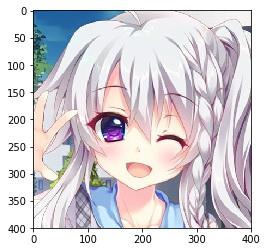

In [3]:
image = mh.imread('./data/ch10/sample.jpg')  
plt.imshow(image)
image.shape # 高さ，幅，次元

JPEGやPNGなど，メジャーなフォーマットならば基本的に読み込める．  
mahotasはデータ値が浮動小数点型でも対応している．  
浮動小数点に対応していない場合にも，浮動小数点型に変換することで丸め誤差やオーバーフローを軽減できる．  

mh.imreadはnumpy 配列を返す．  
例えば画像の平均値を差し引くことで照明の異なる環境で撮影された画像を正規化することができる．  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


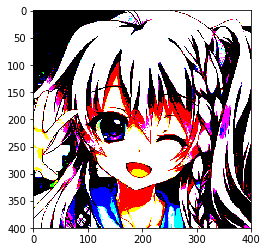

In [4]:
norm_image = image - image.mean() # マイナスの値があるとClippingとしてwarningされる．
plt.imshow(norm_image)

## 基本的な画像処理
まずは，本書のために収集した，建物，風景，テキストの3つのクラスについてそれぞれ30枚の画像データを利用する．    
ダウンロードは[ここ](https://github.com/luispedro/BuildingMachineLearningSystemsWithPython)からできる．  
リポジトリをGit cloneしてしまい，SimpleImageDatasetディレクトリを任意の場所に配置．  
こっちに修正版のコードとか色々上がってたのね．．．

まずはbuilding05.jpgを例として使う．  

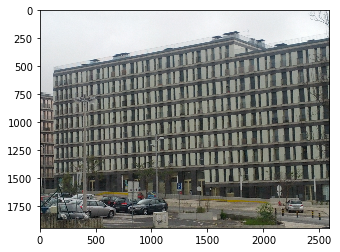

In [5]:
image = mh.imread("./data/ch10/SimpleImageDataset/building05.jpg")
plt.imshow(image)

### 閾値処理
閾値を超えていればTrue,そうでなければFalseにして2値化する．  
この閾値の設定は統計的に行うことができ，いくつか手法がある．  
手法の一つに，大津の2値化という手法がある．  
<br>
2値化の前に，まずは画像をグレースケールにする．  
各チャンネルの平均によるグレースケール画像は以下のようになる．  

In [3]:
def grayshow(image):
    plt.imshow(image)
    plt.gray() # 疑似カラー画像ではなく，グレースケール画像として表示

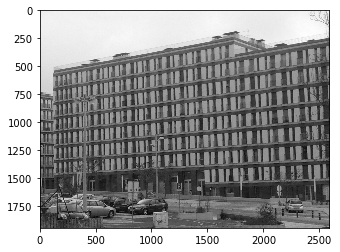

In [7]:
mean_gray_image = image.mean(axis=2, dtype=int) # チャンネル方向に平均
grayshow(mean_gray_image)

mahotasのrgb2grayの方が，人間の目に対してより自然な結果になる．  
人間の目はRGBの3つの基本色に対して同様な感度ではないことに起因する．  

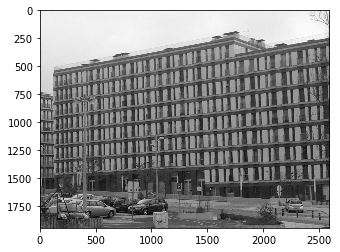

In [8]:
gray_image = mh.colors.rgb2gray(image, dtype=np.uint8)
grayshow(gray_image)

大津の2値化を利用して2値化を行う．

164


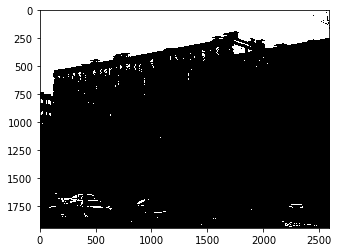

In [9]:
thresh = mh.thresholding.otsu(gray_image)
print(thresh)
grayshow(gray_image > thresh)

上部にある空から建物と駐車場の領域が分離されたことがわかる．

さらに，ノイズ除去を行なっていく．  

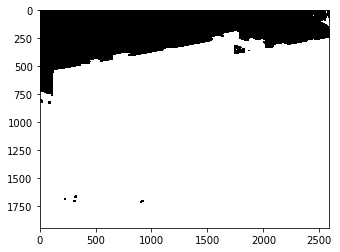

In [10]:
otsubin = (gray_image <= thresh)
otsubin = mh.close(otsubin, np.ones((15, 15))) # 指定した範囲より小さい領域を閉じることができる．
grayshow(otsubin)

逆の操作で建物を黒にする．

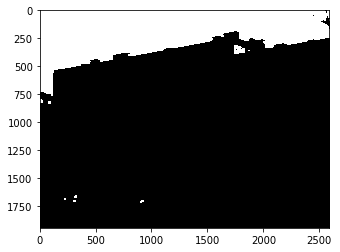

In [11]:
otsubin = (gray_image > thresh)
otsubin = mh.open(otsubin, np.ones((15, 15)))
grayshow(otsubin)

駐車場付近の拾いきれていない点はあとで改善を行う．  

大津の2値化によって，空の領域を特定することができた．  
次はRibler-Calvard手法を利用してみる．  

137.55008050401858


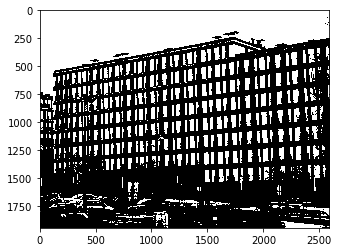

In [12]:
thresh = mh.thresholding.rc(gray_image)
print(thresh)
grayshow(gray_image > thresh)

こちらは建物の細部がはっきりする．  
どちらの方が良い2値化かは，タスクによる．

### ガウシアンぼかし
画像をぼかすことでノイズを除去する．

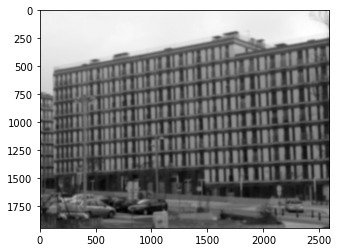

In [13]:
im8 = mh.gaussian_filter(gray_image, 8) # 8はフィルタのサイズ(フィルタの標準偏差)， 値を大きくするとぼかしの度合いが大きくなる．
grayshow(im8)

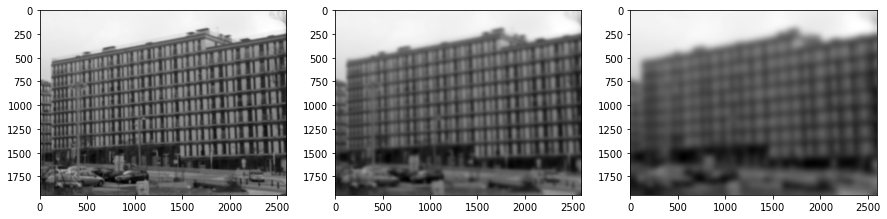

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 10))
for i in range(3):
    axs[i].imshow(mh.gaussian_filter(gray_image, 2 ** (i +3))) # 8, 16, 32
plt.gray()

ぼかしを行なった画像に大津の2値化を行うと，きれいに空と建物を分離できる．  

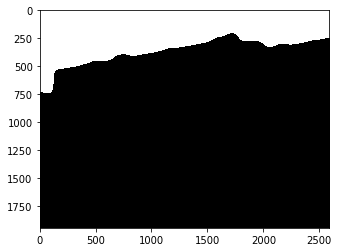

In [15]:
gaussian_image = mh.gaussian_filter(gray_image, 32)
gaussian_thresh = mh.thresholding.otsu(np.asarray(gaussian_image, dtype=np.uint8))
gaussian_otsubin = (gaussian_image > gaussian_thresh)
gaussian_otsubin = mh.open(gaussian_otsubin, np.ones((15, 15)))
grayshow(gaussian_otsubin)

### エフェクトのためのフィルタ処理
ここでは有名なlennaの画像を利用する．ググって手に入れる．  

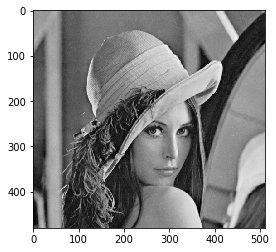

In [16]:
lenna = mh.imread('./data/ch10/lenna.jpg', as_grey=True) # 最初からグレースケール画像として取得
grayshow(lenna)

## ソルト&ペッパーノイズを加える
スキャナーで読み込んだ時のノイズをシミュレーションするためにソルト＆ペッパーノイズをくわえる．

In [4]:
def salt_and_pepper_noise(image, rate=0.975, salt=170, pepper=30):
    salt_filter = np.random.random(image.shape) > rate # 白
    pepper_filter = np.random.random(image.shape) > rate # 黒

    image = mh.stretch(image) # 最大255, 最小0の画像に変換する
    image = np.maximum(salt_filter * salt, image) # saltのところは少なくとも170以上になるようにする
    image = np.minimum(pepper_filter * pepper + image * (~pepper_filter), image) # pepperのところは大きくても30になるようにする
    
    return image

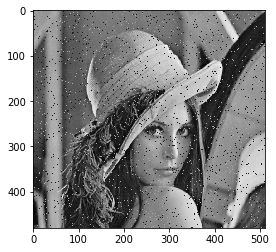

In [18]:
sp_lenna = salt_and_pepper_noise(lenna)
grayshow(sp_lenna)

### 中心部にフォーカスを当てる
1. カラーチャンネルを分離
2. それぞれのチャンネルにガウシアンフィルタをかける
3. ガウシアンフィルタをかけた各チャンネルを合成
4. 画像の中心から対象ピクセルまでの距離を計算し，外側にいくほどフィルタ画像のブレンドが強くなるようにする．

In [5]:
def focus_center(image, blur=12):
    rgb = image.transpose(2, 0, 1) # mahotasの画像はg, b, rの順に色が入っている
    rgblur = [mh.gaussian_filter(c, blur) for c in rgb]
    imblur = mh.as_rgb(*rgblur)
    
    h, w = imblur.shape[:2]
    Y, X = np.mgrid[:h, :w] # (h, w)の2次元配列を2つ生成，Y: 行に同じ数, X: 列に同じ数， となっており，(X, Y)が組み合わせになっている．    
    Y = Y - h/2 # 中央値を0にする
    Y = Y / np.abs(Y).max() # -1~1の範囲に正規化
    X = X - w/2
    X = X / np.abs(X).max()
    
    # gaussian関数で中心部分が大きい値を持つようにする
    W = np.exp(-2. * (X**2 + Y**2)) # 負の値をなくしつつ， 負の指数関数で外側にいくほど小さな値になるような重みを生成
    W = W - W.min() # 最小値を0にする
    W = W / W.ptp() # ptp: peak to peak: 最大値 - 最小値, 今最小値は0なので実質最大値で除算をしており，最大値を1にしている．
    W = W[:, :, None] # imageと次元を合わせるため，ダミーの3次元目のデータを追加
    
    ringed = mh.stretch(image * W + (1 - W) * imblur) # 外側にいくほど元画像の要素が小さく， 逆に内側にいくほどぼかし画像の要素が大きくなるよう加算
    return ringed

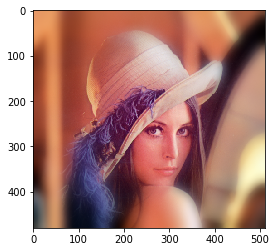

In [20]:
lenna = mh.imread('./data/ch10/lenna.jpg')
ringed_lenna = focus_center(lenna)
plt.imshow(ringed_lenna)

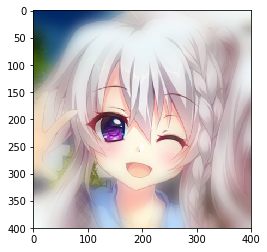

In [21]:
image = mh.imread('./data/ch10/sample.jpg')  
ringed_sample = focus_center(image)
plt.imshow(ringed_sample)

以上のようにしてフィルタを作っていける．  
この分野は科学というよりも芸術に近いと言える．

## パターン認識
文字認識などのパターン認識において，全てのピクセルを特徴量として学習アルゴリズムに与えることは良い考えではない．  
各ピクセルの関連性，小さいピクセル領域の関連性は最終的な結果と直接関係することがないからである．  
その代わり，画像から特徴量を抽出してクラス分類を行うのが一般的なアプローチになる．  
ニューラルネットワークなど，ピクセル値をそのまま用いる手法も色々研究されている．  
また，パターン認識とはここでは画像におけるクラス分類のことになっている．

## 画像から特徴量を計算する
mahotasの特徴量計算モジュールを利用する．  
Haralickテクスチャ特徴量というものを利用する．  
これによって，風景のような滑らかな画像と，本のような模様のある画像を識別することができる．  

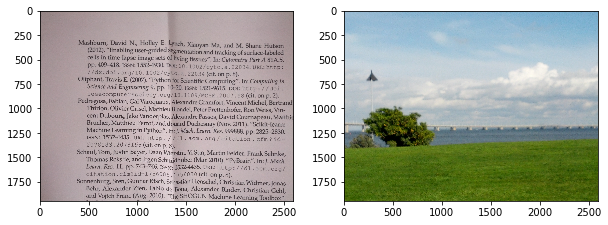

In [22]:
text_image = mh.imread("./data/ch10/SimpleImageDataset/text21.jpg")
scene_image = mh.imread("./data/ch10/SimpleImageDataset/scene00.jpg")

fig, axs = plt.subplots(ncols=2, figsize=(10, 20))
axs[0].imshow(text_image)
axs[1].imshow(scene_image)

In [23]:
haralick_features_text = np.mean(mh.features.haralick(text_image), 0)
haralick_features_scene = np.mean(mh.features.haralick(scene_image), 0)

print(haralick_features_text)
print(haralick_features_scene)

[ 9.00899652e-04  1.86917188e+02  9.05571243e-01  9.90467685e+02
  2.02491523e-01  3.26305413e+02  3.77495355e+03  7.53446709e+00
  1.14807563e+01  3.60292185e-04  4.22931106e+00 -2.59201814e-01
  9.69042628e-01]
[ 6.15987785e-04  1.13595955e+03  8.57291321e-01  4.13285392e+03
  1.98094927e-01  2.91464172e+02  1.53954561e+04  8.34672587e+00
  1.21238011e+01  3.59294480e-04  4.84451279e+00 -3.70156916e-01
  9.92506033e-01]


4×13の配列が返される．  
1つ目の次元には上下左右の4つの方向について特徴量が計算されている．  
方向について興味がなければ，全方向の平均を用いる．

他にも，LInear Binary Patternsという特徴量がある．  
こちらはテクスチャベースの特徴量であり，照明の変化に対してロバストな特性を持つ．    
<br>
画像から特徴量を抽出することで，クラス分類だけでなく，クラスタリング，回帰，次元削減などを行うこともできる．  
さらに，2次元の特徴量ならば可視化を行うことができる．  
<br>
これらの特徴量を用いて，クラス分類を行ってみる．  
まずは全てのデータから特徴量を抽出する．

In [6]:
import os
from glob import glob

def image_features_and_labels(datapath, feature_func, label_func):
    images = glob(os.path.join(datapath, "*.jpg"))
    features = []
    labels = []
    for image_path in images:
        image = mh.imread(image_path, as_grey=True).astype(np.uint8)
        features.append(feature_func(image))
        labels.append(label_func(image_path))
    return np.array(features), np.array(labels)

In [7]:
feature_haralick = lambda image: np.mean(mh.features.haralick(image), 0)
label_simple = lambda image_path: os.path.split(image_path)[-1][:-len('00.jpg')]

haralick_features = lambda: image_features_and_labels("./data/ch10/SimpleImageDataset", feature_haralick, label_simple)
features, labels = create_or_load_pickle("./data/ch10/hararick_features.pkl", haralick_features, create_new=False)
print(features.shape)
print(labels.shape)

./data/ch10/hararick_features.pkl was loaded from the pickle file.
(90, 13)
(90,)


ロジスティック回帰による分類を行なってみる．

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, LeaveOneOut # 最新コードの方はLeaveOneOutでテストしていたのでやってみる

In [27]:
print(cross_val_score(LogisticRegression(), features, labels, cv=5).mean())
print(cross_val_score(LogisticRegression(), features, labels, cv=LeaveOneOut().split(features)).mean())

0.7222222222222222
0.7222222222222222


3つのクラスは大きく異なったテクスチャを持つ．  
「建物」： シャープな線と同系色の大きな領域  
「テキスト」： 明暗が鋭く変化する箇所が多く存在，大量の白い領域の中に黒い領域が少し存在  
「風景」： フラクタルのような構造，滑らかな変化  
3つのクラスは大きく異なっているため，良い成果を期待できるが，実際は72％程度の精度（79%って書いてあるけど）  

## 自分で特徴量を設計する
特徴量は様々あるが，それぞれに強みを持つように設計されている．  
重要でない要因にできるだけ普遍であるように設計されているものの例として，先ほど出てきたLinear Binary Patterns特徴量がある．  
これは全ピクセルに対してある数字をかけて一定の数を足し合わせても不変な特徴量を得られる．  
この特性のため，照明の変化に対してロバストになる．　　  
<br>
また，テキスト画像のような特殊なケースには，画像の「エッジさ」を重要視した特徴量があると良い．  
それには，昔からよく利用される，エッジ検出を行う手法，ソーベルフィルタを使う．  
ソーベルフィルタでは，2つの行列で画像にフィルタ処理をかける．  
垂直方向には次の行列を用いる．  
$$ \left( \begin{array}{ccc} 1 & 0 & 1 \\ -2 & 0 & -2 \\ 1 & 0 & 1 \end{array} \right)$$
横方向には次の行列を用いる．
$$ \left( \begin{array}{ccc} 1 & -2 & 1 \\ 0 & 0 & 0\\ 1 & -2 & 1 \end{array} \right)$$
各ピクセルで両方向のコンボリューションの結果を足し合わせる．  
別々にコンボリューションを使って，縦方向と横方向のそれぞれのエッジの検出にも利用できる．  

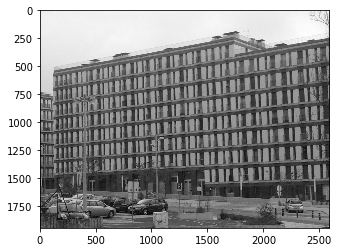

In [28]:
image = mh.imread("./data/ch10/SimpleImageDataset/building05.jpg", as_grey=True)
grayshow(image)

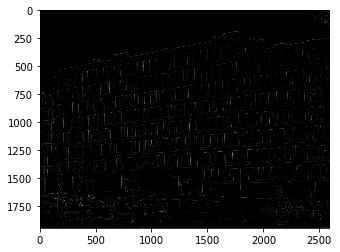

In [29]:
sobel_filtered = mh.sobel(image, just_filter=True)
grayshow(sobel_filtered)

なんかちがくね？

このフィルタに基づいて，画像全体のエッジについての情報である大域特徴量を定義したい．

In [9]:
def edginess_sobel(image):
    edges = mh.sobel(image, just_filter=True)
    edges = edges.ravel()
    return np.sqrt(np.dot(edges, edges)) # エッジの内積をとってルート． どれだけエッジが効いている画像であるかを1つの値にする．

In [10]:
feature_sobel_haralick = lambda image: np.concatenate((feature_haralick(image), [edginess_sobel(image)]))
haralick_sobel_features = lambda: image_features_and_labels("./data/ch10/SimpleImageDataset", feature_sobel_haralick, label_simple)
features, labels = create_or_load_pickle("./data/ch10/hararick_sobel_features.pkl", haralick_sobel_features)
print(features.shape)
print(labels.shape)

./data/ch10/hararick_sobel_features.pkl was loaded from the pickle file.
(90, 14)
(90,)


In [11]:
print(cross_val_score(LogisticRegression(), features, labels, cv=5).mean())
print(cross_val_score(LogisticRegression(), features, labels, cv=LeaveOneOut().split(features)).mean())

0.8444444444444444
0.8333333333333334


エッジの強さを特徴量に加えた結果，正解率は84%になった．  
良いアルゴリズムを用いること自体は簡単である．  
どのような特徴量をデザインするかということ，つまり特徴エンジニアリングにこそ価値があると言える．

# より難しいデータセットを分類する
テクスチャではうまく分類できないようなデータセットが与えられることもある．  
そういった場合に対応できるより高度な手法を見ていく．  
まずはデータセットを入手する．  

``` bash
> wget http://vision.stanford.edu/Datasets/AnimTransDistr.rar
> unrar x AnimTransDistr.rar
# The following file is a broken file:
> rm Anims/104034.jpg
```

動物，車，交通機関，風景の4つのクラスがある．  
次の動物，車の画像のように，どちらも自然物を背景としており，滑らかな領域が多く含まれるため，テクスチャを目印とした分類は難しそうである．  

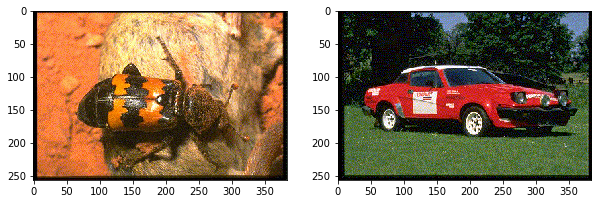

In [33]:
anim_ex = mh.imread("./data/ch10/StanfordDataset/Anims/35131.jpg")
car_ex = mh.imread("./data/ch10/StanfordDataset/Cars/354025.jpg")

_, axs = plt.subplots(ncols=2, figsize=(10, 15))
axs[0].imshow(anim_ex)
axs[1].imshow(car_ex)

In [12]:
STANFORD_LABELS = ["Anims", "Cars", "Distras", "Trans"]
stanford_feature_sobel_haralick = lambda image: np.concatenate((feature_haralick(image), [edginess_sobel(image)]))
stanford_label = lambda image_path: image_path.split(os.path.sep)[-2]

def stanford_haralick_sobel_features():
    features = []
    labels = []
    for label in STANFORD_LABELS:
        f, l = image_features_and_labels(f"./data/ch10/StanfordDataset/{label}", stanford_feature_sobel_haralick, stanford_label)
        features.append(f)
        labels.append(l)
    return np.vstack(features), np.hstack(labels)

In [13]:
features, labels = create_or_load_pickle("./data/ch10/stanford_hararick_sobel_features.pkl", stanford_haralick_sobel_features)
print(features.shape)
print(labels.shape)

./data/ch10/stanford_hararick_sobel_features.pkl was loaded from the pickle file.
(3979, 14)
(3979,)


In [45]:
print(cross_val_score(LogisticRegression(), features, labels, cv=10).mean())

0.5269731939917823


テクスチャ特徴量を他の手法と組み合わせる必要があるかもしれないが，まずは局所特徴量について見ていきたい．

# 局所特徴量による記述
画像の局所的な領域を対象に計算される特徴量である局所特徴量(Local features)を用いた手法が近年提案されている．  
テクスチャ特徴量の画像全体を対象として特徴量を計算しているのとは対象的である．  
mahotasはSURF(Speeded Up Robust Features)や，もっとも有名でありこの分野のパイオニアであるSIFT(Scale-Invariant FeatureTransform)といった特徴量が設計されている．  
これらの局所特徴量は回転や照明変化にロバストであるように設計されている．  
<br>
これらの特徴量を用いる時には，画像のどの領域を計算するかを以下の3種類から決める．  
- ランダム
- グリッド
- 画像の特徴領域検出(キーポイント検出(keypoint detection), 特徴点検出(interest point detection))など

一般的に，風景画像より人工物の写った写真には，はっきりとしたエッジや角度，コントラストが強い箇所が多いため，特徴点検出がうまくいく．  
ここでは特徴点検出を使う．

In [14]:
from mahotas.features import surf

In [38]:
grey_sample = mh.imread("./data/ch10/StanfordDataset/Anims/35131.jpg", as_grey=True) # surfは2次元データのみに対応
surf_descriptors = surf.surf(grey_sample, descriptor_only=True) # 特徴量の場所，サイズ，その他の情報を受け取らない
dense_descriptors = surf.dense(grey_sample, spacing=16) # 16ピクセル間隔のグリッド状の点における記述子, 特徴量の場所などは固定なので，返らない．
print(surf_descriptors.shape) # サンプル数 * 64 の特徴量． サンプル数は画像のサイズや中身，関数に渡すパラメータによって変動
print(dense_descriptors.shape)

(512, 64)
(128, 64)


descriptorとは記述子のことで，画像中の対象領域を特徴ベクトルに変換した結果．  
これらの記述子をそのままSVMやロジスティック回帰に入力することはできない．  
平均をとったりしても良いが，そうすると位置に関する情報を失うので，大域特徴量とさほど変わりなく，良い結果にはならない．  
<br>
そこで，bag-of-wordsモデルを利用する．  
印字された単語よりも，音声として発せられた単語の方がイメージがしやすい．  
同じ単語であっても，発音されるたびにその波形は微妙に異なる．  
しかし，周波数についてクラスタリングを行うことで，その中心的な構造を見つけ出し，それらの発生された単語が同じクラスになるよう分類できる．  
<br>
画像においては，同じように見える領域を各々，「visual word」と呼び，これらにクラスタリングを行う．  
<br>
ここでいう「単語」の数をいくつにするかは，極端でなければいい．  
例えば，数千枚の画像に10や20程度の単語数ではシステム全体がうまく機能せず，逆にあまりに多くてもうまく行かない．  
両極端の中間であれば結果が安定(結果に大きな影響を与えない)する．  
画像の数が多ければ，256, 512, 1024くらいがちょうど良い．  
<br>
まずは特徴量の計算を行う．

In [15]:
from sklearn.cluster import KMeans

pr = ProgressReporter()

def stanford_surf_features(k=5):
    all_descriptors = []
    labels = []
    
    images = np.concatenate([glob(f"./data/ch10/StanfordDataset/{label}/*.jpg") for label in STANFORD_LABELS])
    
    def iter_func(im_path):
        image = mh.imread(im_path, as_grey=True).astype(np.uint8)
        all_descriptors.append(surf.surf(image, descriptor_only=True))
        labels.append(stanford_label(im_path))

    pr.start(images, iter_func)
        
    concatenated = np.concatenate(all_descriptors)[::32] # スピードを考慮して記述子を少なくする
    km = KMeans(k)
    km.fit(concatenated)
    
    features = []
    for d in all_descriptors:
        c = km.predict(d)
        feature = np.array([np.sum(c == ci) for ci in range(k)])
        features.append(feature)
        
    features = np.array(features)
    
    return features, np.array(labels)

In [ ]:
features, labels = create_or_load_pickle("./data/ch10/stanford_surf_features.pkl", stanford_surf_features, create_new=True)
print(features.shape)
print(labels.shape)

Current progress: 295 / 3979, 20.02 [sec] elapsed
Speed of the progress: 14.74 [item/sec]. The task will be finished in 250.00 [sec]


In [22]:
print(cross_val_score(LogisticRegression(), features, labels, cv=10).mean())

0.6134857152208587


テクスチャベースの特徴量に比べて9%程度の改善が見られた．

In [42]:
hararick_sobel_features, _ = create_or_load_pickle("./data/ch10/stanford_hararick_sobel_features.pkl", stanford_haralick_sobel_features)
features = np.hstack((features, hararick_sobel_features))

print(cross_val_score(LogisticRegression(), features, labels, cv=10).mean())

./data/ch10/stanford_hararick_sobel_features.pkl was loaded from the pickle file.
0.6564562249035152


テクスチャベースの特徴量と合わせることで，13%程度の改善が見られた．